In [39]:
import os
import warnings
from pathlib import Path

import catboost
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from dotenv import load_dotenv
from sklearn.metrics import roc_auc_score

import src.features.basic as ftr_basic
import src.features.transforms as transforms
import src.features.transforms as trf
import src.utils.io as io_utils
import src.visualization.plotting as visual

In [3]:
load_dotenv()
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2


ROOT = Path(os.getenv("ROOT"))
CONFIG_DIR = ROOT / Path("src/config/")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
data_cfg = io_utils.load_yaml(CONFIG_DIR / "data.yaml")
DATA_SPLIT_PATH = data_cfg["split_origin_train_data"]
DATA_NEW_FTR = data_cfg["new_features_train_data"]

data_train = io_utils.load_df_parquet(ROOT / DATA_SPLIT_PATH["train_features_path"])
data_val = io_utils.load_df_parquet(ROOT / DATA_SPLIT_PATH["val_features_path"])

target_train = io_utils.load_df_parquet(ROOT / DATA_SPLIT_PATH["train_target_path"])
target_val = io_utils.load_df_parquet(ROOT / DATA_SPLIT_PATH["val_target_path"])

data_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,blue-collar,married,primary,no,1480,yes,no,unknown,15,may,297,1,-1,0,unknown
1,33,technician,divorced,secondary,no,47,no,no,cellular,7,aug,462,2,-1,0,unknown
2,28,blue-collar,single,primary,no,554,yes,no,telephone,13,may,531,1,-1,0,unknown
3,29,unemployed,single,primary,no,2070,no,no,cellular,3,feb,236,1,-1,0,unknown
4,55,technician,married,secondary,no,865,yes,no,cellular,8,jun,613,2,97,2,success


In [37]:
data_ids = io_utils.load_df_parquet(
    ROOT / data_cfg["origin_train_data_clean"]["ids_path"]
)

In [43]:
def transforms(df: pd.DataFrame) -> pd.DataFrame:
    trans = {
        "was_contact": trf.was_contact(df),
        "credit_score": trf.credit_score(df),
        "job_marital": trf.job_marital(df),
        "job_education": trf.job_education(df),
        "education_marital": trf.education_marital(df),
        "campaign_cat": trf.campaign_categorical(df),
        "pdays_cat": trf.pdays_categorical(df),
        "previous_cat": trf.previous_categorical(df),
        "log_duration": trf.log_duration(df),
        "log_balance": trf.log_balance(df),
        "multiply_logs": trf.multiply_logs(df),
        "is_overdraft": trf.is_overdraft(df),
        "sin_month": trf.sin_month(df),
        "cos_month": trf.cos_month(df),
        "sin_day": trf.sin_day(df),
        "cos_day": trf.cos_day(df),
    }
    df_new = df.copy()
    for col in trans:
        df_new[col] = trans[col]
    return df_new

In [44]:
data_train_new = transforms(data_train)
data_val_new = transforms(data_val)

data_train_new.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,was_contact,credit_score,job_marital,job_education,education_marital,campaign_cat,pdays_cat,previous_cat,log_duration,log_balance,multiply_logs,is_overdraft,sin_month,cos_month,sin_day,cos_day
0,30,blue-collar,married,primary,no,1480,yes,no,unknown,15,may,297,1,-1,0,unknown,0,1,blue-collar_married,blue-collar_primary,primary_married,1,no_contact,0,5.697093,7.300473,41.591476,0,0.866025,-0.500000,0.299363,-0.954139
1,33,technician,divorced,secondary,no,47,no,no,cellular,7,aug,462,2,-1,0,unknown,0,0,technician_divorced,technician_secondary,secondary_divorced,2,no_contact,0,6.137727,3.871201,23.760375,0,-0.500000,-0.866025,0.937752,0.347305
2,28,blue-collar,single,primary,no,554,yes,no,telephone,13,may,531,1,-1,0,unknown,0,1,blue-collar_single,blue-collar_primary,primary_single,1,no_contact,0,6.276643,6.318968,39.661910,0,0.866025,-0.500000,0.651372,-0.758758
3,29,unemployed,single,primary,no,2070,no,no,cellular,3,feb,236,1,-1,0,unknown,0,0,unemployed_single,unemployed_primary,primary_single,1,no_contact,0,5.468060,7.635787,41.752942,0,0.500000,0.866025,0.394356,0.918958
4,55,technician,married,secondary,no,865,yes,no,cellular,8,jun,613,2,97,2,success,1,1,technician_married,technician_secondary,secondary_married,2,<100,<5,6.419995,6.763885,43.424107,0,0.500000,-0.866025,0.988468,0.151428


In [45]:
jbm_enc = trf.JobBalanceEnc()
data_train_new["jb_mean"] = jbm_enc.fit_transform(data_train_new)
data_val_new["jb_mean"] = jbm_enc.transform(data_val_new)

In [46]:
drop_columns = [
    "default",
    "balance",
    "housing",
    "loan",
    "day",
    "month",
    "duration",
    "campaign",
    "pdays",
    "previous",
]

In [47]:
data_train_new = data_train_new.drop(columns=drop_columns)
data_val_new = data_val_new.drop(columns=drop_columns)

data_train_new.head()

,age,job,marital,education,contact,poutcome,was_contact,credit_score,job_marital,job_education,education_marital,campaign_cat,pdays_cat,previous_cat,log_duration,log_balance,multiply_logs,is_overdraft,sin_month,cos_month,sin_day,cos_day,jb_mean
0,30,blue-collar,married,primary,unknown,unknown,0,1,blue-collar_married,blue-collar_primary,primary_married,1,no_contact,0,5.697093,7.300473,41.591476,0,0.866025,-0.500000,0.299363,-0.954139,972.500400
1,33,technician,divorced,secondary,cellular,unknown,0,0,technician_divorced,technician_secondary,secondary_divorced,2,no_contact,0,6.137727,3.871201,23.760375,0,-0.500000,-0.866025,0.937752,0.347305,1073.106634
2,28,blue-collar,single,primary,telephone,unknown,0,1,blue-collar_single,blue-collar_primary,primary_single,1,no_contact,0,6.276643,6.318968,39.661910,0,0.866025,-0.500000,0.651372,-0.758758,972.500400
3,29,unemployed,single,primary,cellular,unknown,0,0,unemployed_single,unemployed_primary,primary_single,1,no_contact,0,5.468060,7.635787,41.752942,0,0.500000,0.866025,0.394356,0.918958,1429.215033
4,55,technician,married,secondary,cellular,success,1,1,technician_married,technician_secondary,secondary_married,2,<100,<5,6.419995,6.763885,43.424107,0,0.500000,-0.866025,0.988468,0.151428,1073.106634


In [48]:
ftr_names = ftr_basic.get_features_names(data_train_new)
cat_features, num_features = ftr_names["categorical"], ftr_names["numeric"]

data_train_new = ftr_basic.cat_features_to_category(data_train_new)
data_val_new = ftr_basic.cat_features_to_category(data_val_new)

data_train_new, data_val_new = ftr_basic.align_categorical_levels(
    data_train_new, data_val_new, cat_features
)

In [49]:
io_utils.save_df_parquet(data_train_new, ROOT / DATA_NEW_FTR["train_new_features_path"])
io_utils.save_df_parquet(data_val_new, ROOT / DATA_NEW_FTR["val_new_features_path"])

In [50]:
model_cfg = io_utils.load_yaml(CONFIG_DIR / "models.yml")["catboost_new_ftr"]

PARAMS_PATH = ROOT / model_cfg["params_path"]
cb_baseline_params = io_utils.load_yaml(PARAMS_PATH)
cb_model_params = cb_baseline_params["params"]
cb_fit_params = cb_baseline_params["fit"]

In [51]:
LOGS_PATH = ROOT / "experiments/logs/caboost_new_ftr"
LOGS_PATH.mkdir(parents=True, exist_ok=True)

train_pool = Pool(data=data_train_new, label=target_train, cat_features=cat_features)
val_pool = Pool(data=data_val_new, label=target_val, cat_features=cat_features)


cb_new_model = CatBoostClassifier(**cb_model_params, train_dir=str(LOGS_PATH))

cb_new_model.fit(train_pool, eval_set=val_pool, **cb_fit_params)

In [52]:
cb_base_best_iter = cb_new_model.get_best_iteration()

meta = {
    "library": "catboost",
    "version": catboost.__version__,
    "planned_params": cb_model_params,
    "fit_params": cb_fit_params,
    "best_iteration": int(cb_base_best_iter),
    "tree_count": int(cb_new_model.tree_count_),
    "feature_order": list(data_train_new.columns),
    "categorical_features": list(cat_features),
}

io_utils.save_yaml(meta, ROOT / model_cfg["meta_path"])
cb_new_model.save_model(ROOT / model_cfg["model_path"])

In [53]:
pred_cb_new = cb_new_model.predict_proba(val_pool)[:, 1]
auc_new = roc_auc_score(target_val, pred_cb_new)

print(f"Baseline CatBoost with origin data auc-roc score: {auc_new:.4f}")

Baseline CatBoost with origin data auc-roc score: 0.9675


In [54]:
metrics = {"auc_val": float(auc_new)}
preds_df = pd.DataFrame(
    {
        "val_ids": data_ids.loc[data_val_new.index, "id"],
        "val_preds": pred_cb_new,
        "val_true": target_val.squeeze(),
    }
)

io_utils.save_df_parquet(preds_df, ROOT / model_cfg["preds_path"])
io_utils.save_yaml(metrics, ROOT / model_cfg["metrics_path"])

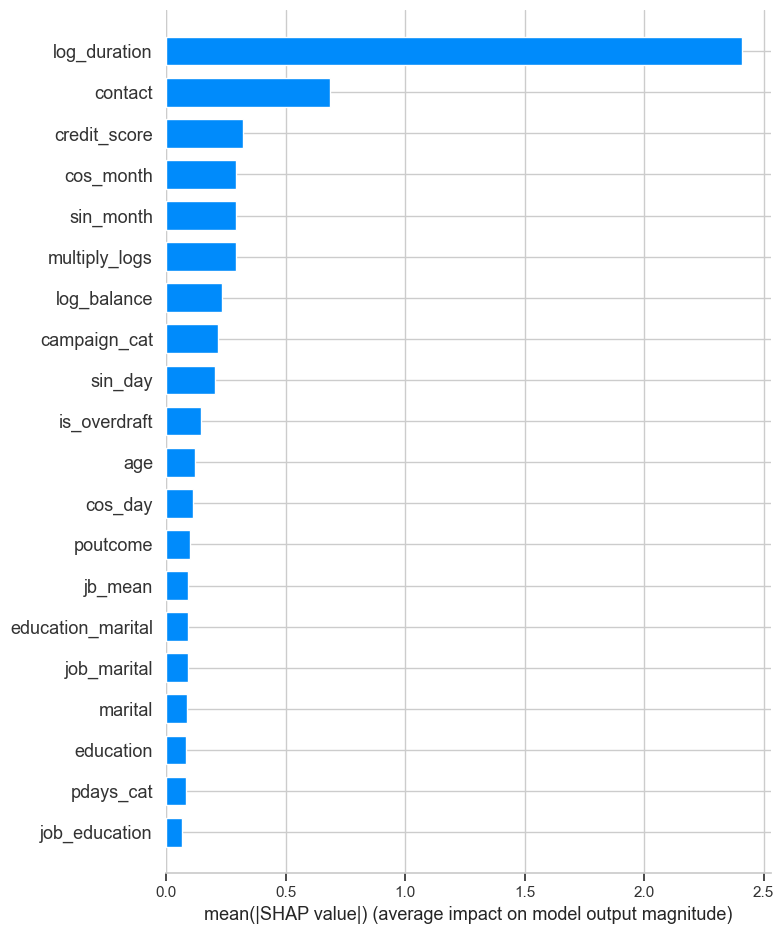

,feature,shap_value
14,log_duration,2.410607
4,contact,0.683638
7,credit_score,0.319738
19,cos_month,0.293435
18,sin_month,0.291711
16,multiply_logs,0.290559
15,log_balance,0.232404
11,campaign_cat,0.217578
20,sin_day,0.202376
17,is_overdraft,0.147392


In [55]:
shap_values = visual.shap_values(cb_new_model, data_train_new)

shap_values